# Sentiment Analysis for The Financial Times

In [1]:
import math
import pickle
from datetime import datetime

import blaze
import matplotlib
import numpy
import pandas as pd
import seaborn as sns
from dateutil.relativedelta import relativedelta
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pymongo import MongoClient

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams['figure.max_open_warning'] = 300

In [104]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len/2-1):-(window_len/2)]


## Data

In [5]:
total_data = pd.read_csv('../nytimes/new_ft_sentences.csv')

In [6]:
total_data.count()

article_id       749551
date             749553
url              457241
source           749553
title            749553
term_category    749553
original_term    749553
search_term      749553
sentence         749553
dtype: int64

In [7]:
total_data_dedup = total_data.drop_duplicates()

In [8]:
total_data_dedup.count()

article_id       749450
date             749452
url              457156
source           749452
title            749452
term_category    749452
original_term    749452
search_term      749452
sentence         749452
dtype: int64

In [9]:
list(total_data_dedup.original_term.value_counts().items())

[('executive', 340068),
 ('manager', 69643),
 ('founder', 34887),
 ('Google', 31867),
 ('microsoft', 30756),
 ('3m company', 27031),
 ('apple', 24672),
 ('ford', 22050),
 ('boeing', 15286),
 ('facebook', 13817),
 ('entrepreneur', 13154),
 ('samsung', 11254),
 ('intel corporation', 10745),
 ('twitter', 10085),
 ('amazon.com', 8607),
 ('visa', 8092),
 ('ebay', 6824),
 ('mcdonalds corporation', 6393),
 ('Voices.com', 5920),
 ('Nordic', 5712),
 ('mckinsey & company', 4790),
 ('blackrock', 4677),
 ('chevron', 4330),
 ('exxon', 3591),
 ('nike', 3437),
 ('wal-mart', 3042),
 ('halliburton company', 2919),
 ('pepsico', 2522),
 ('alcoa', 2218),
 ('caterpillar', 2009),
 ('Stoke Inc', 1856),
 ('netflix', 1683),
 ('SAS', 1509),
 ('conocophillips', 1482),
 ('linkedin', 1326),
 ('Salesforce', 977),
 ('emc corporation', 868),
 ('BERG', 840),
 ('mattel', 793),
 ('Uber', 756),
 ('pricewaterhousecoopers', 704),
 ('spotify', 667),
 ('metlife', 624),
 ('valero', 490),
 ('Exec', 480),
 ('instagram', 472),
 

In [10]:
# Remove
remove_list = ['Become Inc', 'Indeed', 'at&t', 'Signal']

In [11]:
for term in remove_list:
    total_data_dedup = total_data_dedup[total_data_dedup['original_term'] != term]

In [12]:
total_data_dedup.count()

article_id       749450
date             749452
url              457156
source           749452
title            749452
term_category    749452
original_term    749452
search_term      749452
sentence         749452
dtype: int64

In [13]:
total_grouped = total_data_dedup.groupby(['article_id', 'original_term'])['sentence']

In [14]:
def indexes_to_delete(series):
    del_index_list = []
    for i1, s1 in series.items():
        for i2, s2 in series.items():
            if i1 != i2 and s1 in s2:
                del_index_list.append(i1)
                break
    return str(del_index_list)

In [15]:
grouped_indexes = total_grouped.aggregate({'indexes_to_delete': indexes_to_delete})

In [16]:
remove_index_list = list(set(
    [index for index_list in grouped_indexes['indexes_to_delete'] for index in eval(index_list)]
))

In [17]:
data = total_data_dedup.drop(remove_index_list)

In [18]:
data.count()

article_id       749439
date             749441
url              457147
source           749441
title            749441
term_category    749441
original_term    749441
search_term      749441
sentence         749441
dtype: int64

In [19]:
# df = pd.DataFrame([
#                 [1, 'hola', 'Hola mundo'],         # 0
#                 [1, 'nada', 'Nada que ver'],       # 1
#                 [1, 'hola', 'Hola mundo que tal'], # 2
#                 [1, 'hola', 'Hola'],               # 3
#                 [2, 'hola', 'Hola mundo'],         # 4
#                 [2, 'adios', 'Adios'],             # 5
#                 [3, 'adios', 'Adios'],             # 6
#                ], columns=['article_id', 'term', 'sentence'])
# # g = df.groupby(['article_id', 'term'])['sentence'].aggregate({'indexes_to_delete': indexes_to_delete})
# # l = list(set(
# #     [index for index_list in g['indexes_to_delete'] for index in eval(index_list)]
# # ))
# # df2 = df.drop(l)
# dd = blaze.Data(df)

In [20]:
# blaze.by(blaze.merge(dd.article_id, dd.term),
#          total=dd.article_id.count()
#         )

In [21]:
# Change categories: ebay; executive, manager; entrepreneur, founder, new venture, startup

data.ix[data.original_term == 'ebay', 'term_category'] = 2

for term in ['executive', 'manager']:
    data.ix[data.original_term == term, 'term_category'] = 11

for term in ['entrepreneur', 'founder', 'new venture', 'startup']:
    data.ix[data.original_term == term, 'term_category'] = 12

In [22]:
# Total number of articles
data.article_id.value_counts().count()

351839

In [23]:
# Total number of terms
data.original_term.value_counts().count()

98

In [24]:
# Total number of sentences
data.sentence.value_counts().count()

568988

In [25]:
data.to_csv('../nytimes/new_ft_curated_sentences.csv')

## Classifier

In [26]:
# ________________________________________________________________________________
# Training: NC metric='euclidean' shrink_threshold=None use_idf=True ngram_range=(1, 2) random_state=62
# Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
#         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
#         lowercase=True, max_df=1.0, max_features=None, min_df=1,
#         ngram_range=(1, 2), preprocessor=None, stop_words=None,
#         strip...inear_tf=False, use_idf=True)), ('clf', NearestCentroid(metric='euclidean', shrink_threshold=None))])
# train time: 0.838s
# test time:  0.097s
# accuracy:   0.716
# matthews_corrcoef:   0.397
# classification report:
#              precision    recall  f1-score   support

#         neg       0.61      0.64      0.63       228
#         pos       0.79      0.76      0.77       391

# avg / total       0.72      0.72      0.72       619

# confusion matrix:
# [[147  81]
#  [ 95 296]]


In [27]:
with open('sentiment/pipeline_nc.pickle', 'rb') as be_file:
    be = pickle.load(be_file)

In [28]:
be.predict(['My puppy is cute.', 'People die in war.', 'I love my family.'])

array(['pos', 'neg', 'pos'], dtype=object)

In [37]:
def split_dataframe(df, n):
    d = {}
    length = len(df)
    chunk_size = math.ceil(length / n)
    n_max = math.ceil(length / chunk_size)
    for i in range(min(n, n_max)):
        d[i] = df[chunk_size * i: chunk_size * (i + 1)]
    return d

In [38]:
def analyze_sentiment(df, i):
    df['sentiment'] = df.sentence.map(lambda x: be.predict([x])[0])
    df.to_csv('../nytimes/new_ft_data_{}.csv'.format(i))
    print('DataFrame saved in data_{}.csv'.format(i))

In [39]:
N = 8
data_dict = split_dataframe(data, N)
# for i in range(N):
#     analyze_sentiment(data_dict[i], i)
Parallel(n_jobs=8)(delayed(analyze_sentiment)(data_dict[i], i) for i in range(N))

DataFrame saved in data_2.csv
DataFrame saved in data_1.csv
DataFrame saved in data_6.csv
DataFrame saved in data_7.csv
DataFrame saved in data_4.csv
DataFrame saved in data_0.csv
DataFrame saved in data_5.csv
DataFrame saved in data_3.csv


[None, None, None, None, None, None, None, None]

In [69]:
data_blaze = blaze.Data('../nytimes/new_ft_data_*.csv', delimiter=',')

In [70]:
data_blaze.count()

749475

In [71]:
sentiment_data_ind = blaze.odo(data_blaze, pd.DataFrame)
sentiment_data = sentiment_data_ind.drop('Unnamed: 0', axis=1) #comentar esta linea
# sentiment_data = blaze.odo(data_blaze, pd.DataFrame)

In [72]:
sentiment_data.head()

,article_id,date,url,source,title,term_category,original_term,search_term,sentence,sentiment
0,040429008280,20040429,http://search.ft.com/search/article.html?id=04...,ftcom,Google's rivals in search for supremacy,2,microsoft,microsoft,and Microsoft.,pos
1,040429008280,20040429,http://search.ft.com/search/article.html?id=04...,ftcom,Google's rivals in search for supremacy,2,Google,google,"has pulled off a series of acquisitions, inclu...",pos
2,040429008280,20040429,http://search.ft.com/search/article.html?id=04...,ftcom,Google's rivals in search for supremacy,2,Google,google,Earlier this year it dropped the Google search...,pos
3,040429008280,20040429,http://search.ft.com/search/article.html?id=04...,ftcom,Google's rivals in search for supremacy,2,Google,google,Yahoo could now be better placed than Google t...,pos
4,040429008280,20040429,http://search.ft.com/search/article.html?id=04...,ftcom,Google's rivals in search for supremacy,2,Google,google,user spends nearly three hours a month on the ...,pos


In [73]:
# Delete startup
sentiment_data = sentiment_data[sentiment_data.original_term != 'startup']

In [74]:
# Total number of articles
sentiment_data.article_id.value_counts().count()

351792

In [75]:
# Total number of terms
sentiment_data.original_term.value_counts().count()

97

In [76]:
# Total number of sentences
sentiment_data.sentence.value_counts().count()

568789

In [77]:
def diff_month(d1, d2):
    d1 = datetime.strptime(str(d1), '%Y%m%d')
    d2 = datetime.strptime(str(d2), '%Y%m%d')
    return (d2.year - d1.year) * 12 + d2.month - d1.month

# assert diff_month(20100901, 20101001) == 1
# assert diff_month(20091001, 20101001) == 12
# assert diff_month(20091101, 20101001) == 11
# assert diff_month(20090801, 20101001) == 14

In [78]:
sentiment_data['n_month'] = sentiment_data.date.apply(lambda x: diff_month(20030101, x))

In [79]:
data2 = blaze.Data(sentiment_data)

In [80]:
blaze.by(data2.term_category,
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

,term_category,amount_neg,amount_pos,total_amount
0,2,106342,156621,262963
1,3,8780,19644,28424
2,11,188155,221574,409729
3,12,12703,35343,48046


In [81]:
# Old classifier --> more positive

# blaze.by(data2.term_category,
#    total_amount=data2.sentiment.count(),
#    amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
#    amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
# )

#  	term_category 	amount_neg 	amount_pos 	total_amount
# 0 	2 	106075 	251088 	357163
# 1 	3 	18546 	62625 	81171
# 2 	11 	206396 	200361 	406757
# 3 	12 	9900 	79663 	89563

## Visualizations

In [82]:
grouped_by_category = blaze.by(blaze.merge(data2.term_category, data2.n_month),
    total_amount=data2.sentiment.count(),
    amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
    amount_neg=data2[data2.sentiment == 'neg'].sentiment.count(),
)

grouped_by_term = blaze.by(blaze.merge(data2.original_term, data2.n_month),
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

In [83]:
grouped_by_category

,term_category,n_month,amount_neg,amount_pos,total_amount
0,2,0,446,596,1042
1,2,1,329,486,815
2,2,2,415,488,903
3,2,3,350,494,844
4,2,4,400,510,910
5,2,5,397,571,968
6,2,6,400,543,943
7,2,7,369,517,886
8,2,8,410,572,982
9,2,9,493,750,1243


In [88]:
def plot(term_list=None, same=False, info='total', category_list=None, figsize=(16, 8), window_len=20, window='hanning'):
    if term_list and not same:
        for term in term_list:
            df = blaze.odo(grouped_by_term[grouped_by_term.original_term == term], pd.DataFrame)
            df.set_index('n_month', inplace=True)
            df.index = [datetime.strptime("2003-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
            df['pos_rate'] = df['amount_pos'] / df['total_amount']
            y1_df = df[['total_amount', 'amount_pos', 'amount_neg']]
            y1_df.plot(title=term, figsize=figsize)
            y2 = smooth(
                    df['pos_rate'].values,
                    window_len=window_len,
                    window=window
            )
            y2_df = pd.DataFrame(y2, columns=['pos_rate'], index=df.index)
            y2_df.plot(title=term, ylim=[0, 1], color='green', figsize=figsize)
    elif term_list and same:
        ax = plt.figure(figsize=figsize).add_subplot(1, 1, 1)
        for term in term_list:
            df = blaze.odo(grouped_by_term[grouped_by_term.original_term == term], pd.DataFrame)
            df.set_index('n_month', inplace=True)
            df.index = [datetime.strptime("2003-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
            df['pos_rate'] = df['amount_pos'] / df['total_amount']
            if info == 'total':
                y = smooth(
                    df['total_amount'].values,
                    window_len=window_len,
                    window=window
                )
                y_df = pd.DataFrame(y, columns=['total_amount'], index=df.index)
                y_df.plot(title='All together', figsize=figsize, ax=ax)
            else:
                y = smooth(
                    df['pos_rate'].values,
                    window_len=window_len,
                    window=window
                )
                y_df = pd.DataFrame(y, columns=['pos_rate'], index=df.index)
                y_df.plot(title='All together', ylim=[0, 1], figsize=figsize, ax=ax)
        ax.legend(term_list)
    elif category_list:
        category_dict = {
            11: 'executive/manager',
            12: 'entrepreneur/founder/new venture',
            2: 'big companies',
            3: 'new companies',
        }
        if not same:
            for category in category_list:
                df = blaze.odo(grouped_by_category[grouped_by_category.term_category == category], pd.DataFrame)
                df.set_index('n_month', inplace=True)
                df.index = [datetime.strptime("2003-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
                df['pos_rate'] = df['amount_pos'] / df['total_amount']
                y1_df = df[['total_amount', 'amount_pos', 'amount_neg']]
                y1_df.plot(title=category_dict[category], figsize=figsize)
        else:
            ax = plt.figure(figsize=figsize).add_subplot(1, 1, 1)
            for category in category_list:
                df = blaze.odo(grouped_by_category[grouped_by_category.term_category == category], pd.DataFrame)
                df.set_index('n_month', inplace=True)
                df.index = [datetime.strptime("2003-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
                df['pos_rate'] = df['amount_pos'] / df['total_amount']
                y2 = smooth(
                        df['pos_rate'].values,
                        window_len=window_len,
                        window=window
                )
                y2_df = pd.DataFrame(y2, columns=['pos_rate'], index=df.index)
                y2_df.plot(title='All together', ylim=[0, 1], figsize=figsize, ax=ax)
            ax.legend(['new companies', 'big companies', 'entrepreneur/founder', 'executive/manager'])

# Images

## Fig.1 Distribution of sentences by category over the period 2003 to 2014

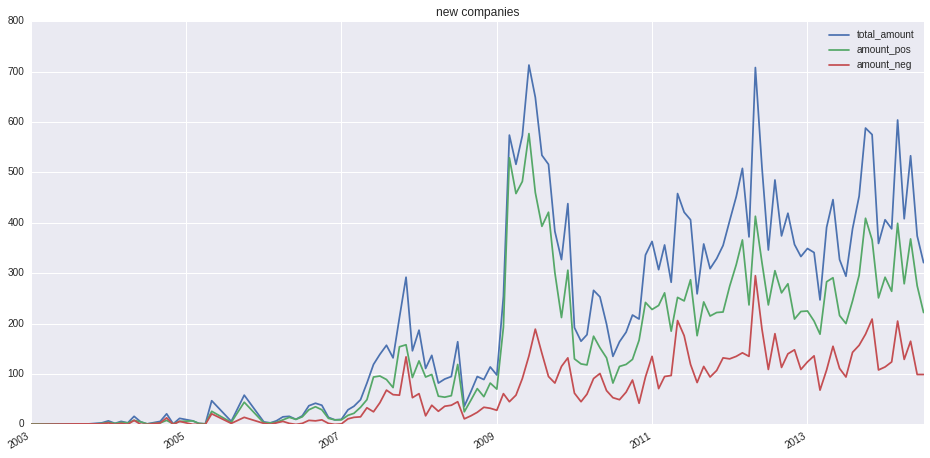

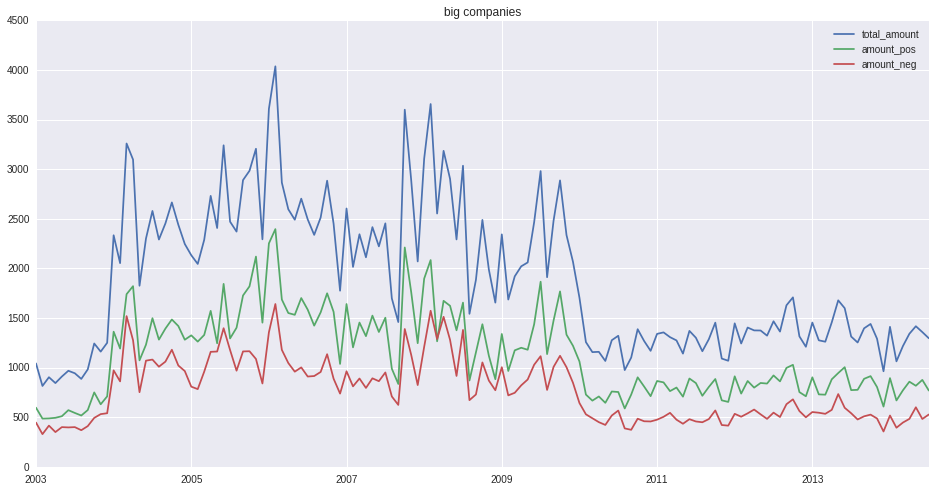

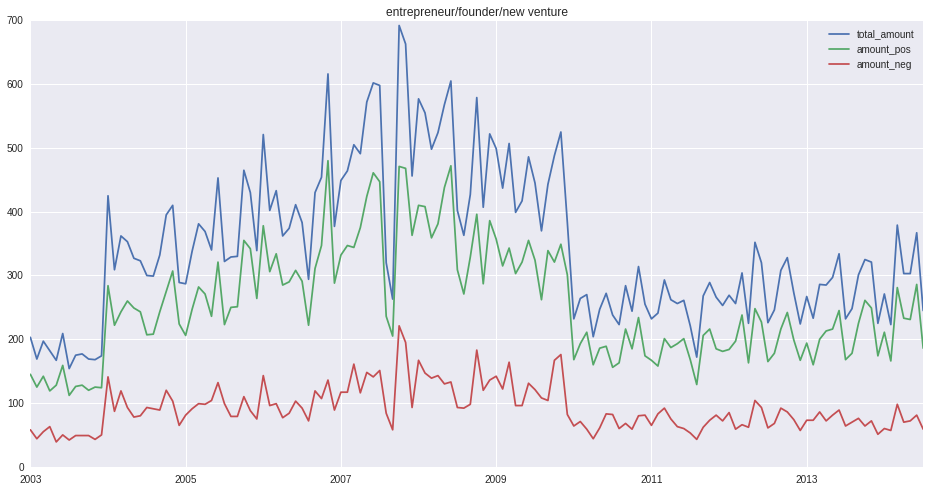

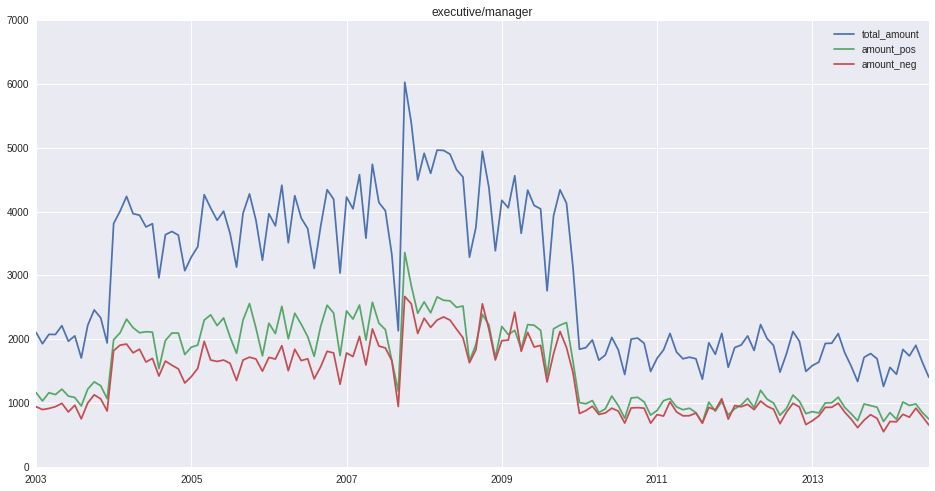

In [105]:
plot(category_list=[3,2, 12,11], info='total', same=False)

## Fig.2 Positive rate of sentences by category over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


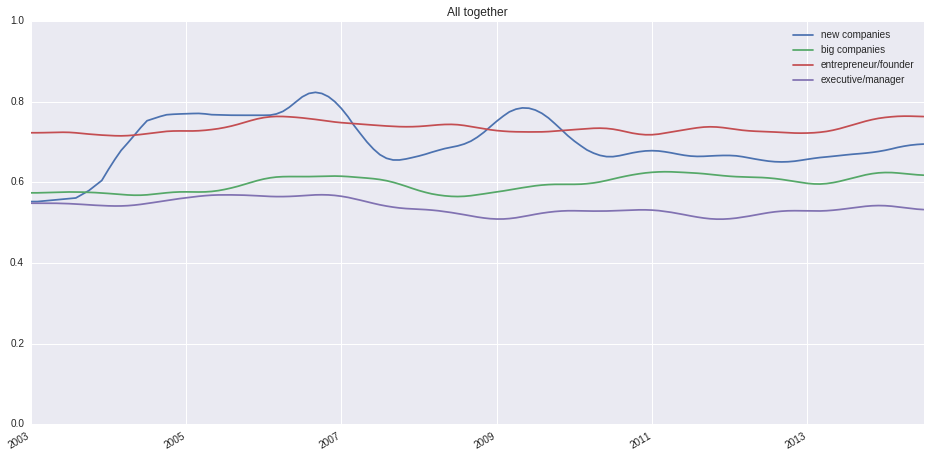

In [106]:
plot(category_list=[3,2, 12,11], info='pos_rate', same=True)

## Fig.3 Distribution of sentences by profession over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


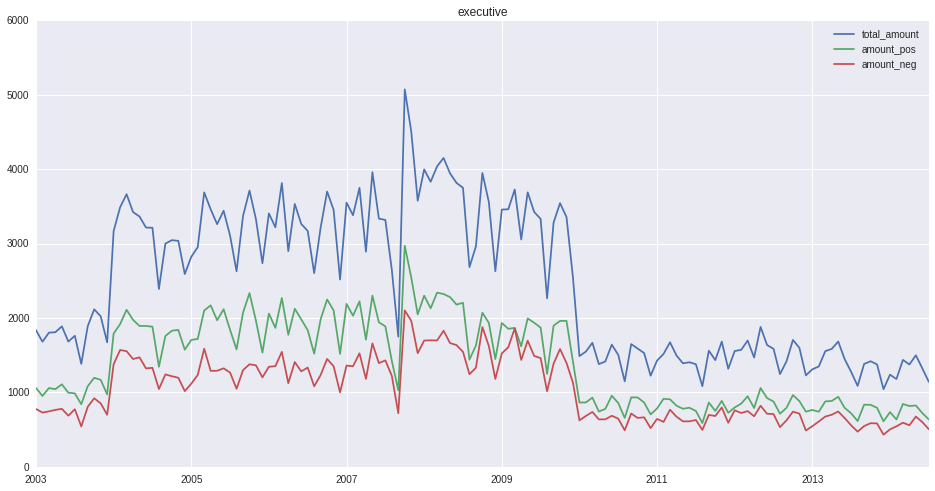

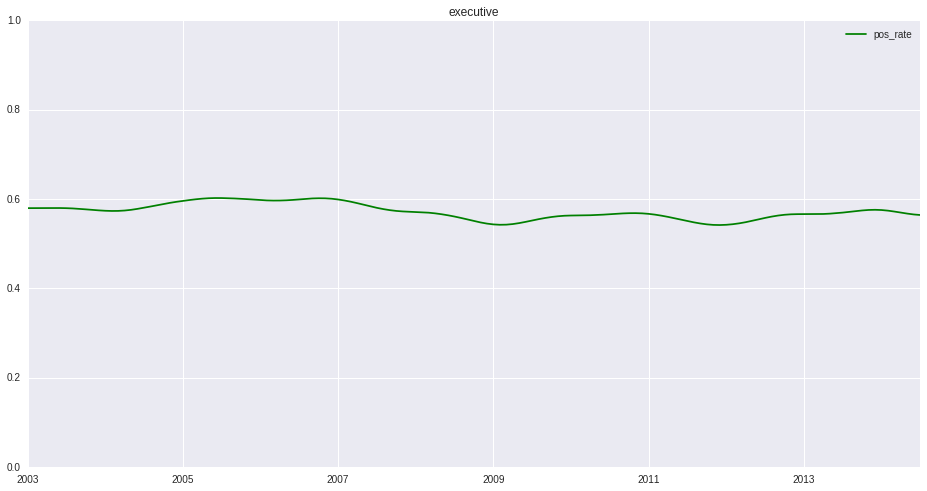

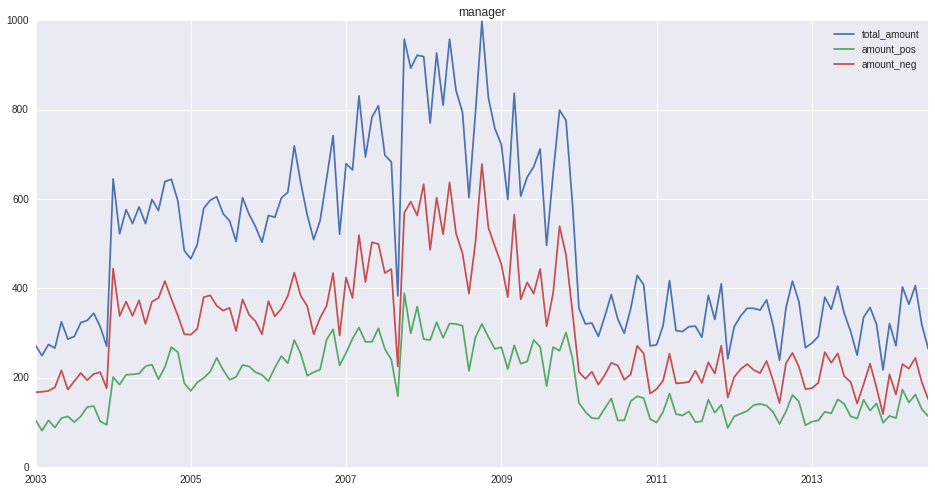

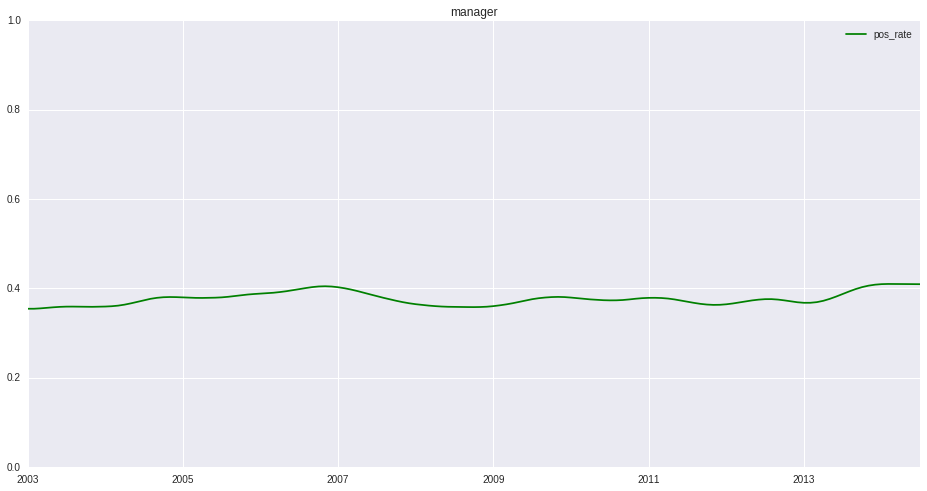

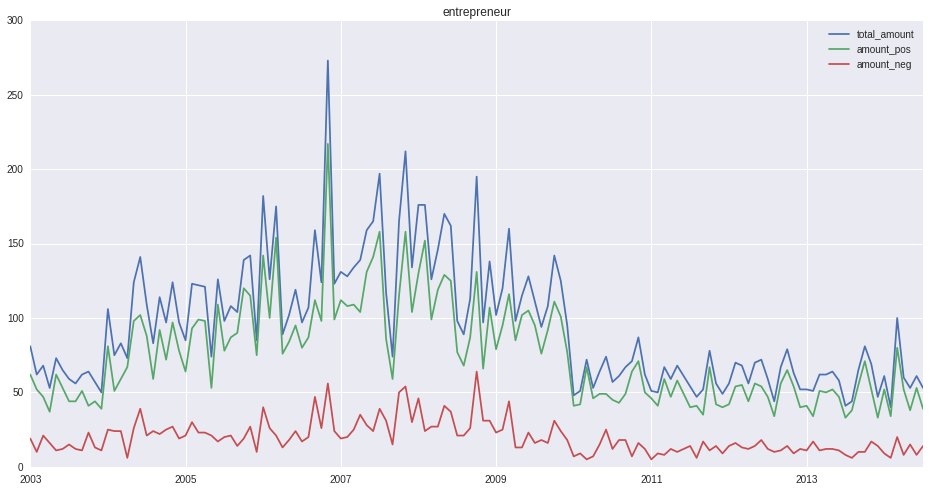

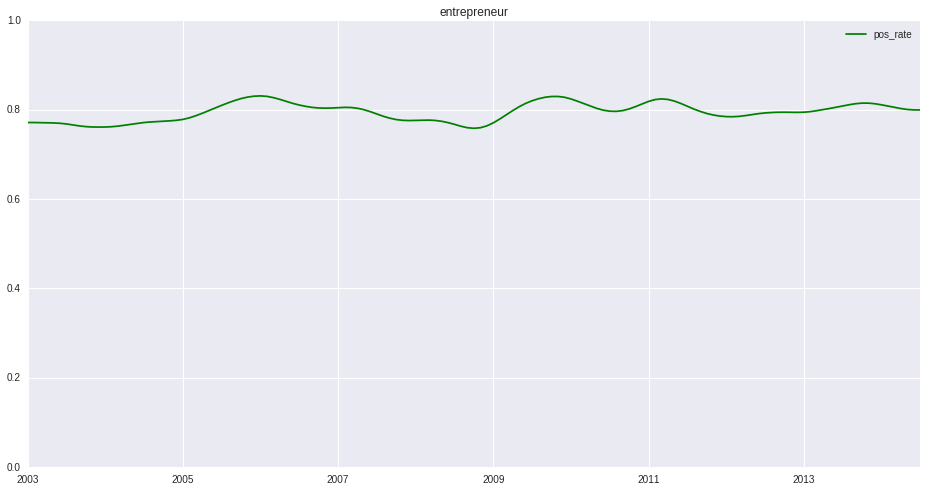

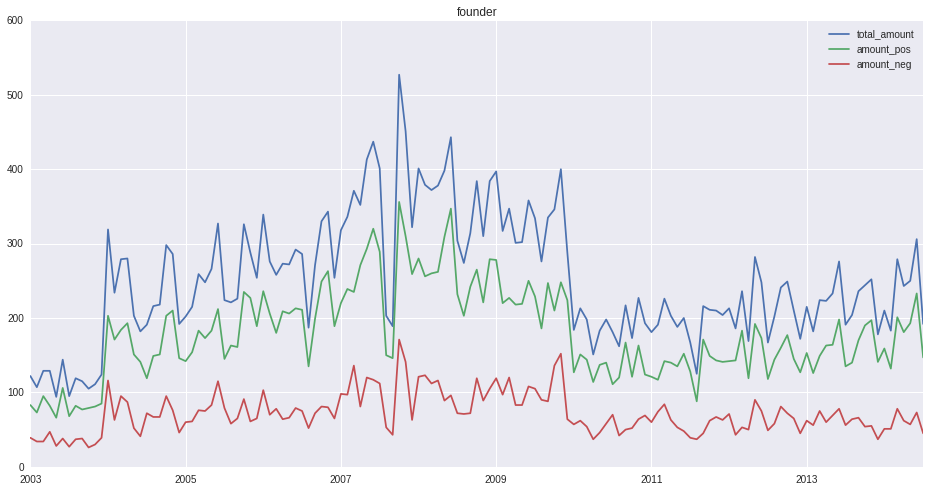

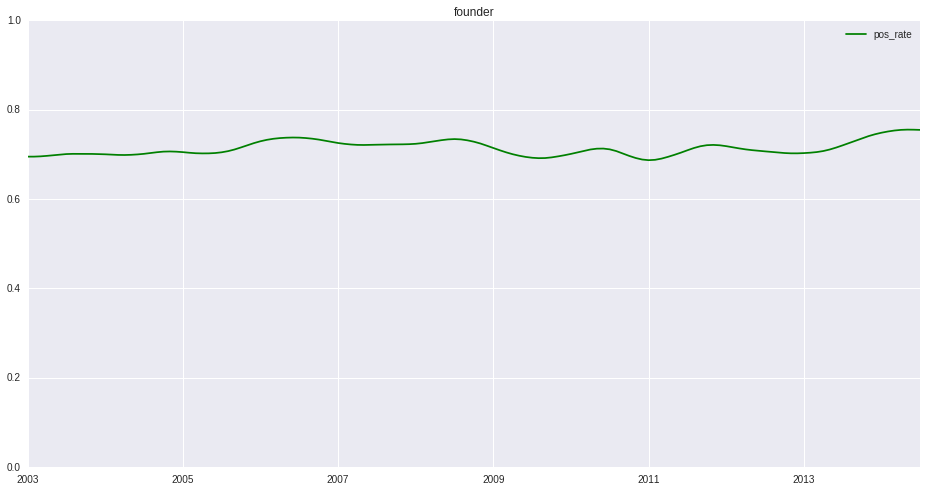

In [107]:
plot(term_list=['executive', 'manager', 'entrepreneur', 'founder'], info='total', same=False)

## Fig.4 Positive rate of sentences by profession over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


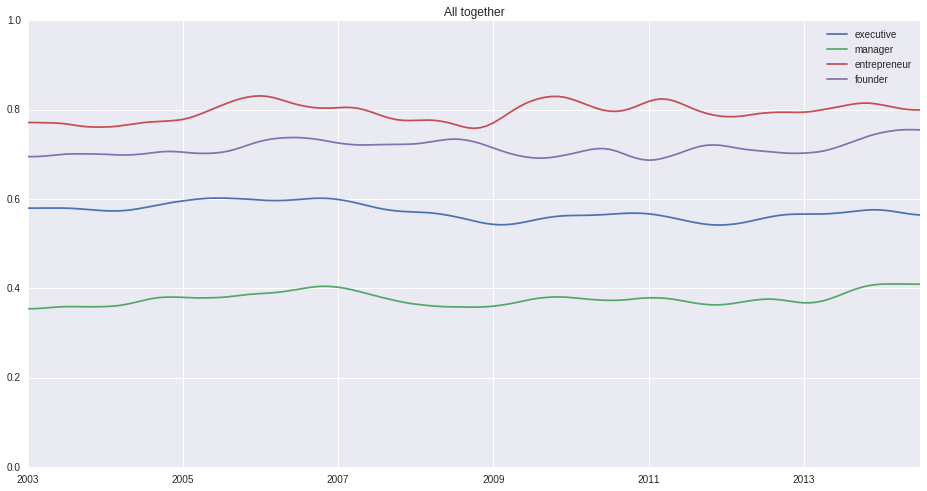

In [108]:
plot(term_list=['executive', 'manager', 'entrepreneur', 'founder'], info='pos_rate', same=True)

## Fig.5 Distribution of sentences for big companies over the period 2003 to 2014

In [116]:
grouped_by_term[grouped_by_term.original_term == 'mckinsey & company'].count()

139

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


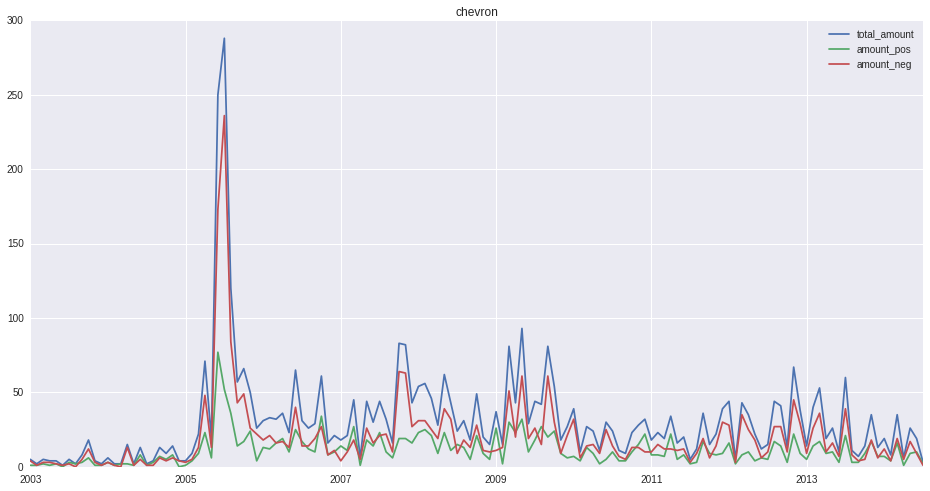

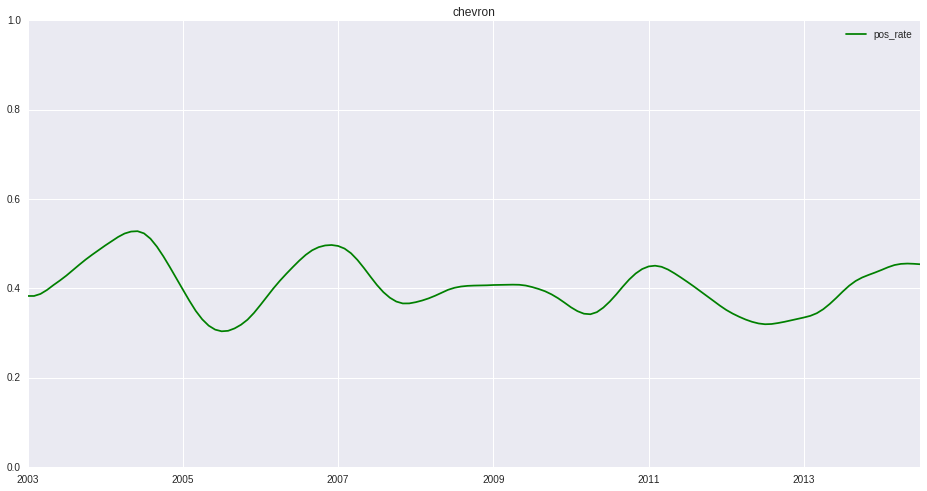

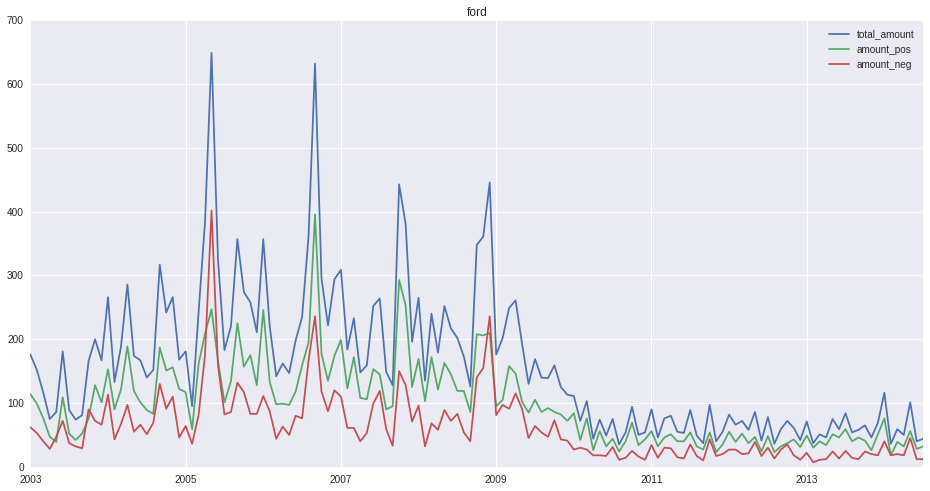

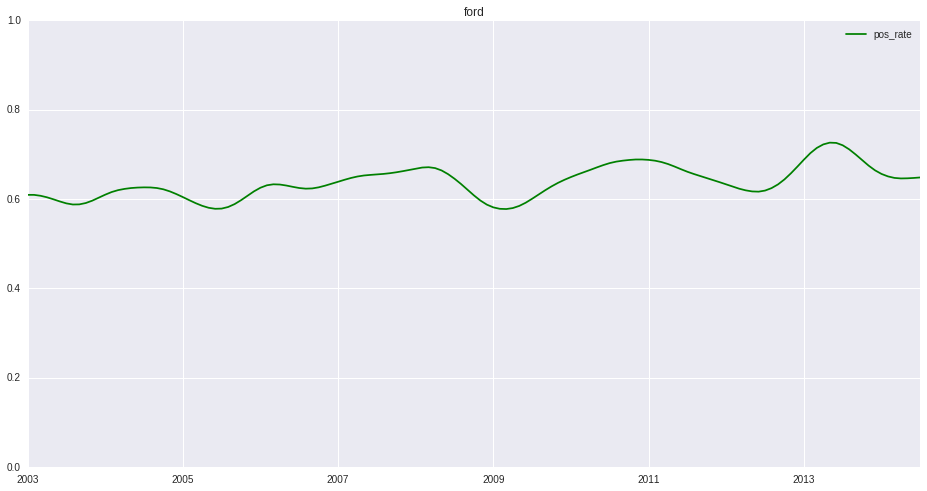

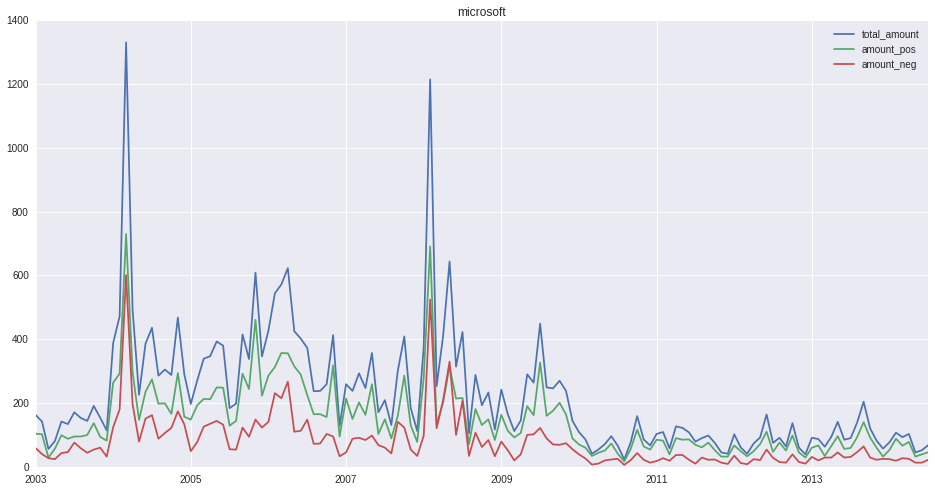

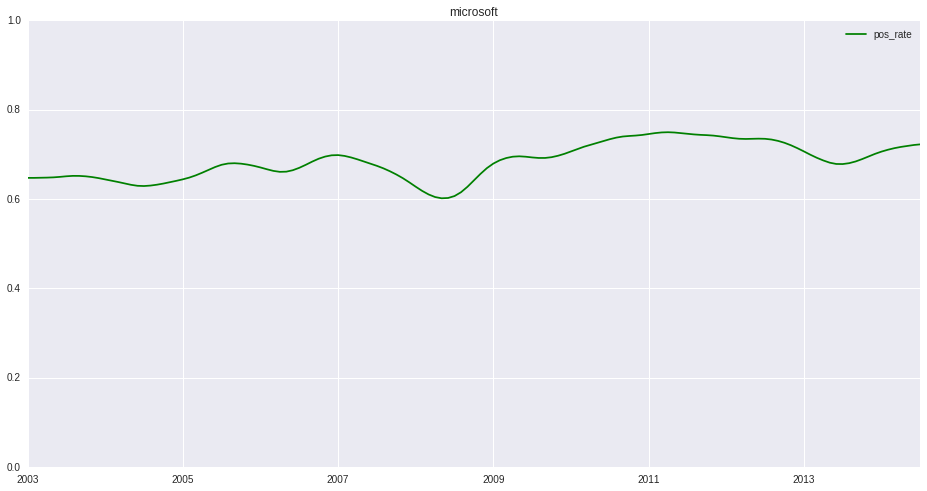

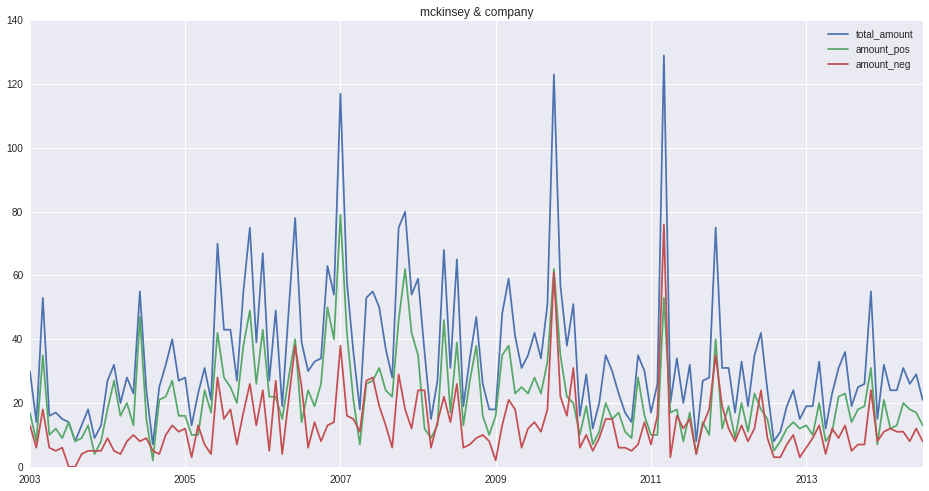

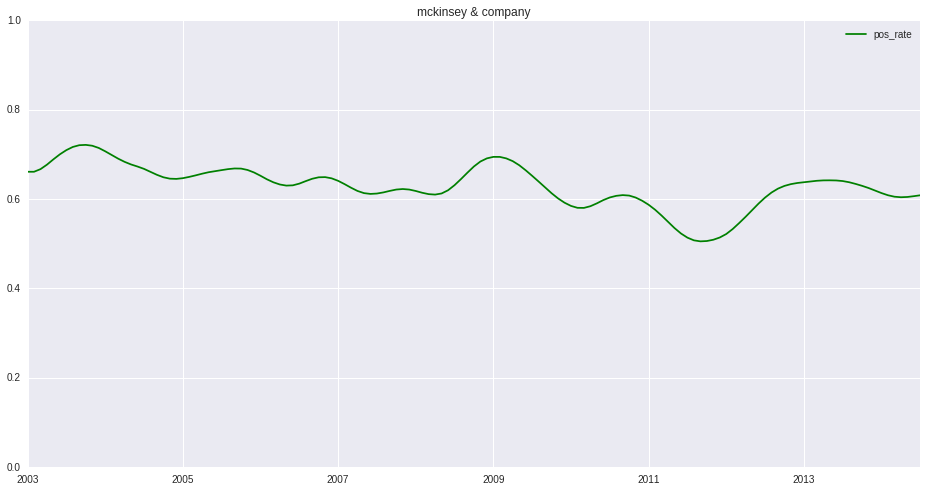

In [117]:
# plot(term_list=['chevron', 'coca-cola company', 'ford', 'general motors', 'microsoft', 'mckinsey & company'], info='total', same=False)
plot(term_list=['chevron', 'ford', 'microsoft', 'mckinsey & company'], info='total', same=False)

## Fig.6 Positive rate of sentences for big companies over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


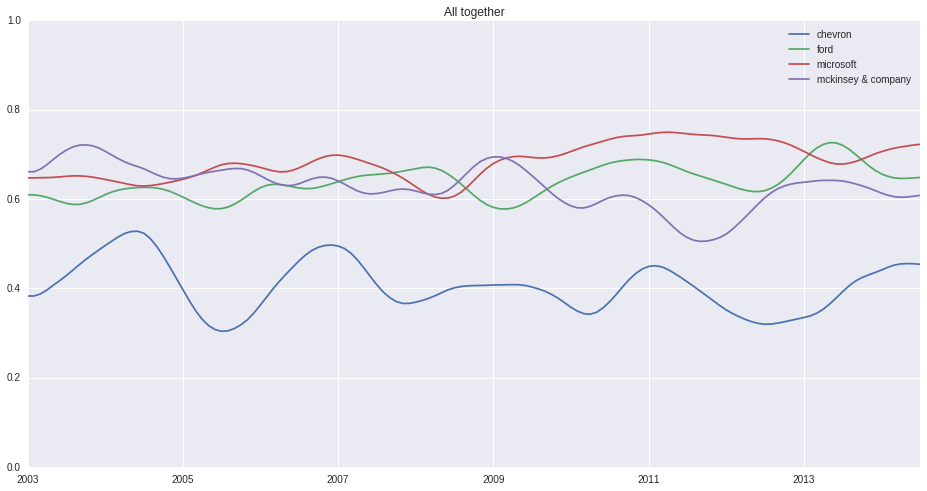

In [120]:
# plot(term_list=['chevron', 'coca-cola company', 'ford', 'general motors', 'microsoft', 'mckinsey & company'], info='pos_rate', same=True)
plot(term_list=['chevron', 'ford', 'microsoft', 'mckinsey & company'], info='pos_rate', same=True)

## Fig.7 Distribution of sentences for new companies over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


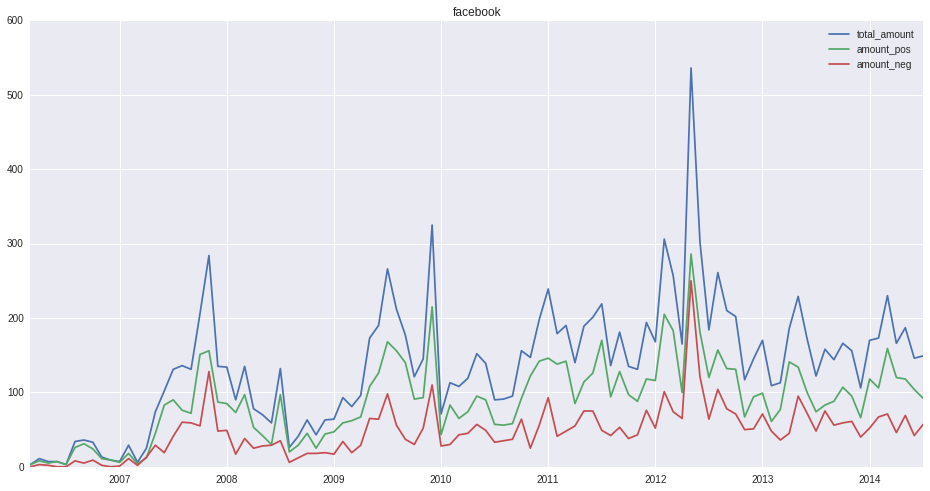

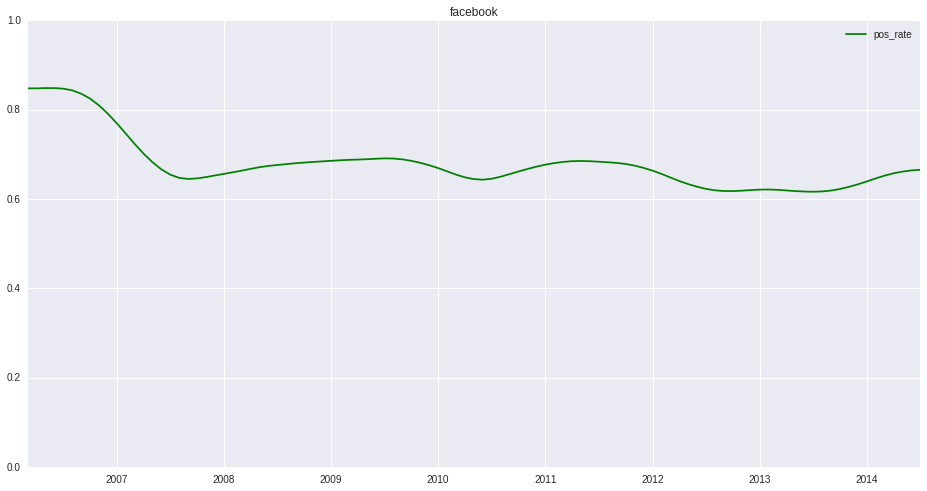

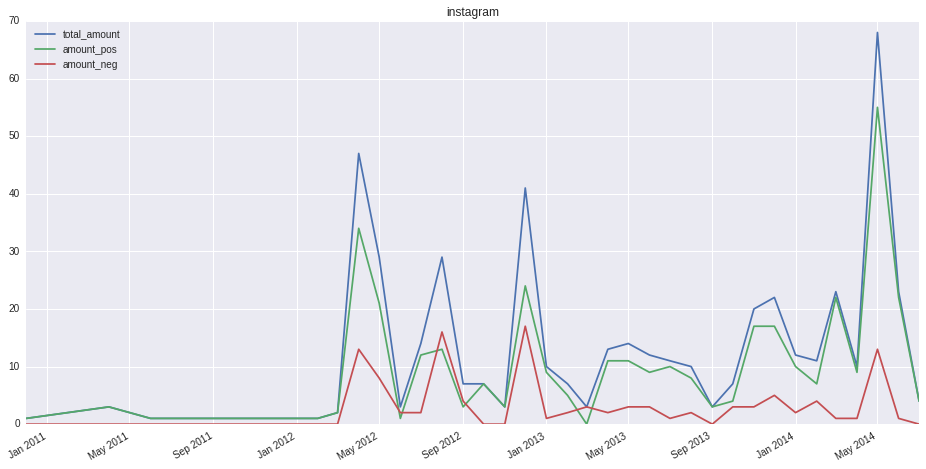

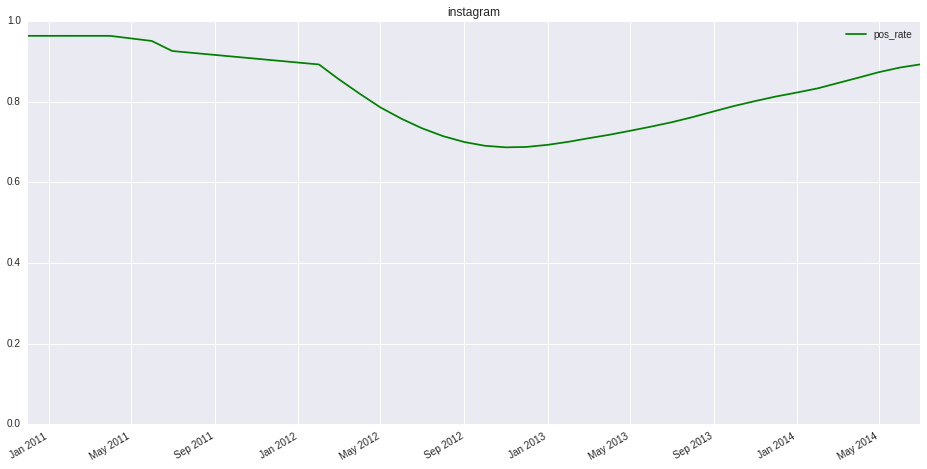

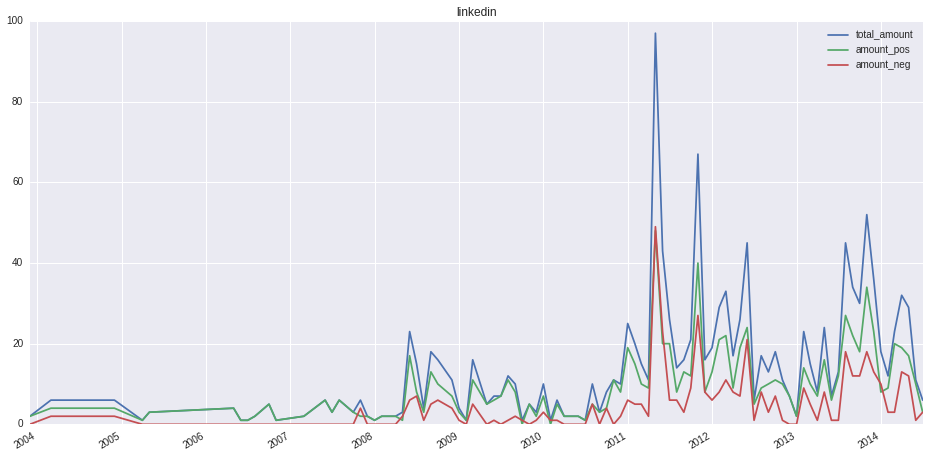

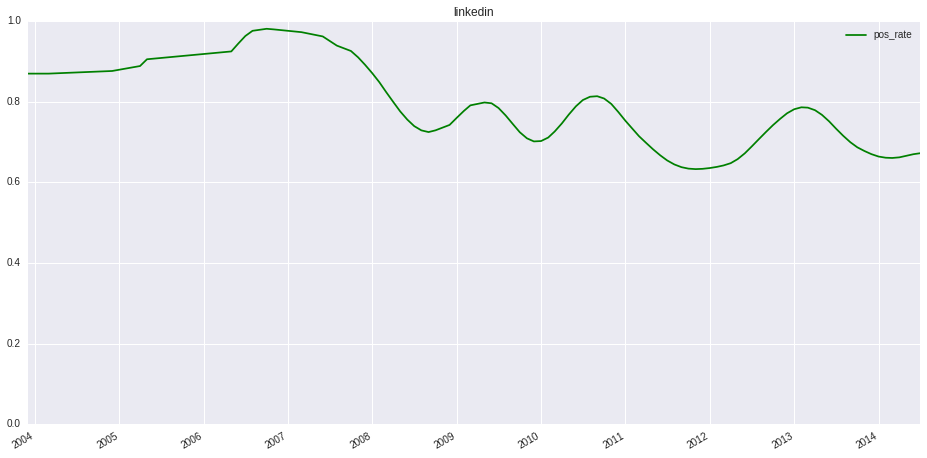

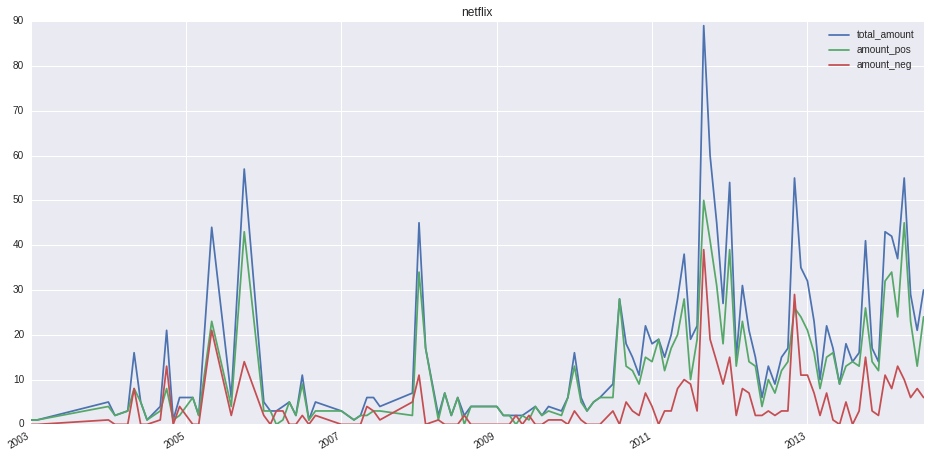

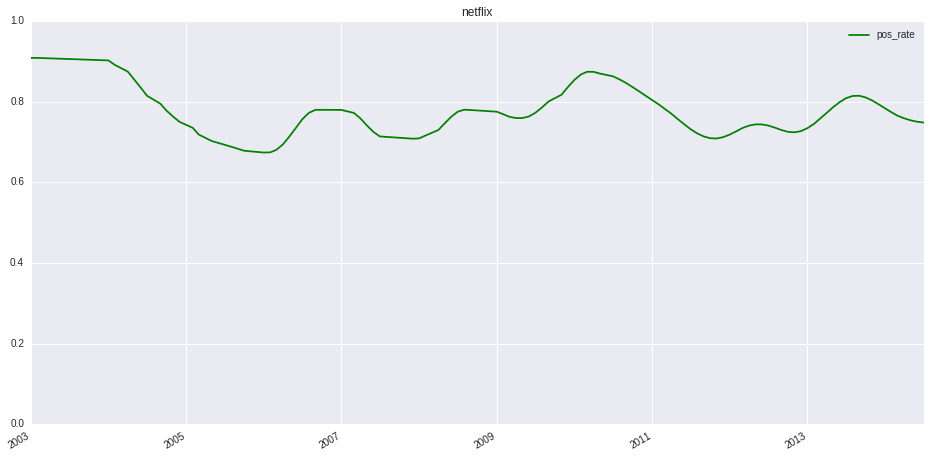

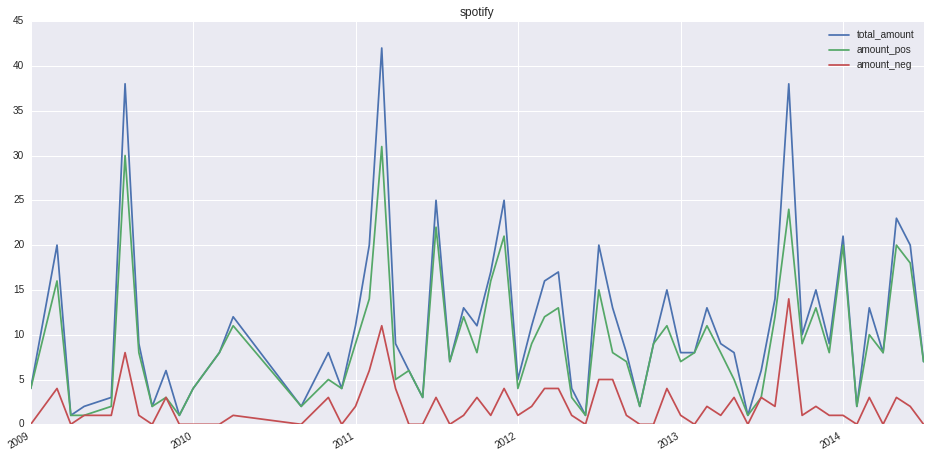

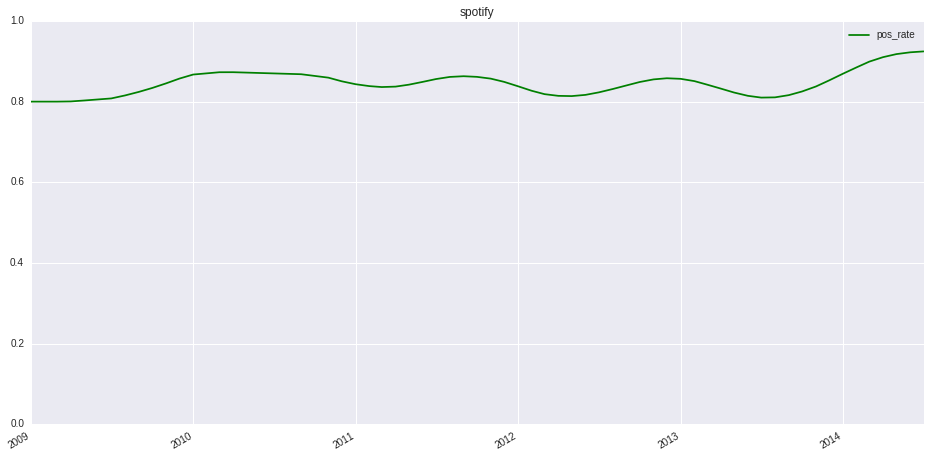

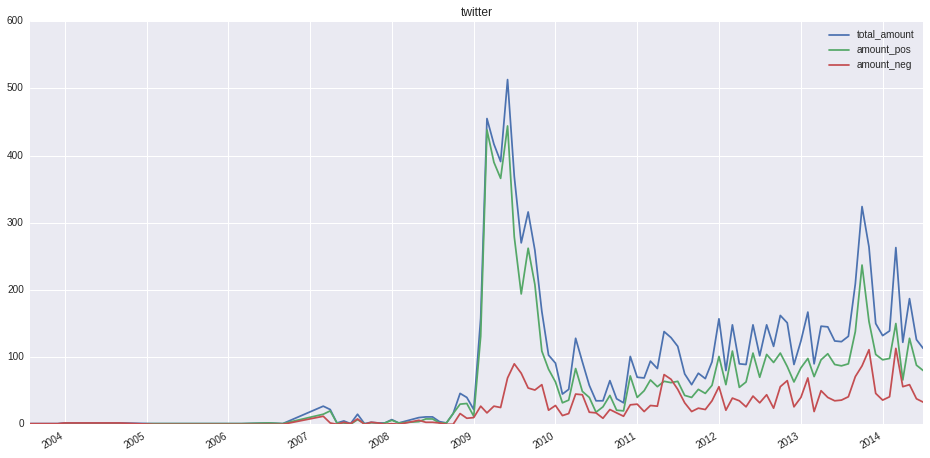

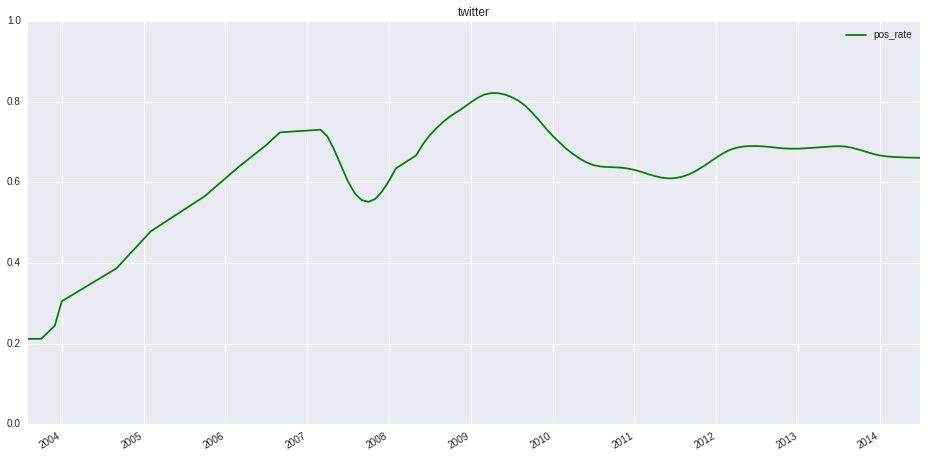

In [121]:
plot(term_list=['facebook', 'instagram', 'linkedin', 'netflix', 'spotify', 'twitter'], info='total', same=False)

## Fig.8 Positive rate of sentences for new companies over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


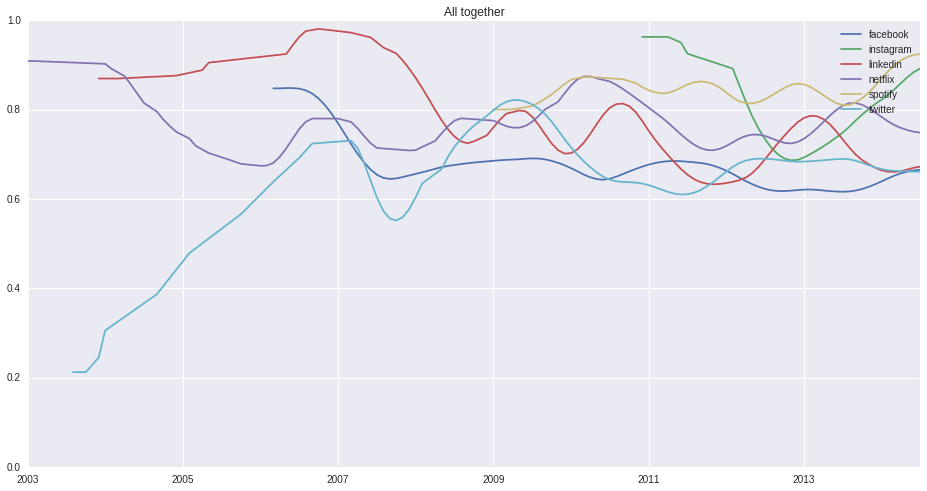

In [122]:
plot(term_list=['facebook', 'instagram', 'linkedin', 'netflix', 'spotify', 'twitter'], info='pos_rate', same=True)